In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip cache purge

Files removed: 2946


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/data_cleaned.csv')

In [3]:
df.head()

,Cleaned_Reviews,Sentiment
0,pro pair switch well multiple device android p...,1
1,sound quality okay price light comfortable sma...,0
2,easy operate good product quality satisfied,2
3,hoping blow head still attached pretty quiet e...,1
4,despite apple airpods earbuds trick responsive...,2


In [4]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['Sentiment']),
    y=df['Sentiment']
)
tf_class_weights = {i: weight for i, weight in enumerate(class_weights)}
print("\nTensorFlow Class Weights:", tf_class_weights)


TensorFlow Class Weights: {0: 1.9867904319885754, 1: 1.1429451632778804, 2: 0.6166204986149585}


train/test split with same ratio of classes

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['Sentiment']):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 13356, Test size: 3339


Stratified Split Train into train/validation sets

In [6]:
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # 20% of train for validation
for train_index, val_index in sss_val.split(train_df, train_df['Sentiment']):
    train_split_df = train_df.iloc[train_index]
    val_df = train_df.iloc[val_index]
print(f"Training size: {len(train_split_df)}, Validation size: {len(val_df)}")

Training size: 10684, Validation size: 2672


tokenize train and test data

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(reviews):
    return tokenizer(reviews, padding=True, truncation=True, return_tensors="tf")

train_encodings = tokenize_function(train_split_df['Cleaned_Reviews'].tolist())
val_encodings = tokenize_function(val_df['Cleaned_Reviews'].tolist())
test_encodings = tokenize_function(test_df['Cleaned_Reviews'].tolist())

create tf datasets

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_split_df['Sentiment'].values
)).shuffle(10000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_df['Sentiment'].values
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['Sentiment'].values
)).batch(16)

compile DistilBERT model

In [9]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

train model

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    class_weight=tf_class_weights,
                    callbacks=[early_stopping],
                    )

Epoch 1/10
668/668 [==============================] - 641s 924ms/step - loss: 0.6841 - accuracy: 0.7239 - val_loss: 0.4625 - val_accuracy: 0.8121
Epoch 2/10
668/668 [==============================] - 617s 923ms/step - loss: 0.4209 - accuracy: 0.8550 - val_loss: 0.5039 - val_accuracy: 0.7964
Epoch 3/10
668/668 [==============================] - 617s 924ms/step - loss: 0.2624 - accuracy: 0.9140 - val_loss: 0.4623 - val_accuracy: 0.8215
Epoch 4/10
668/668 [==============================] - 617s 924ms/step - loss: 0.1599 - accuracy: 0.9478 - val_loss: 0.4580 - val_accuracy: 0.8458
Epoch 5/10
668/668 [==============================] - 617s 923ms/step - loss: 0.1065 - accuracy: 0.9626 - val_loss: 0.5215 - val_accuracy: 0.8570
Epoch 6/10
668/668 [==============================] - 617s 924ms/step - loss: 0.0775 - accuracy: 0.9748 - val_loss: 0.5916 - val_accuracy: 0.8424


evaluate on test dataset

In [11]:
eval_loss, eval_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {eval_acc}")

209/209 [==============================] - 63s 302ms/step - loss: 0.4972 - accuracy: 0.8338
Test Accuracy: 0.8337825536727905


predictions

In [12]:
predictions_logits = model.predict(test_dataset)  # Get predictions
predictions = np.argmax(predictions_logits.logits, axis=1)
true_labels = test_df['Sentiment'].values

209/209 [==============================] - 64s 301ms/step


In [13]:
report = classification_report(true_labels, predictions, target_names=['negative', 'neutral', 'positive'])
print(report)

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76       560
     neutral       0.69      0.80      0.74       974
    positive       0.96      0.87      0.91      1805

    accuracy                           0.83      3339
   macro avg       0.80      0.81      0.81      3339
weighted avg       0.85      0.83      0.84      3339



In [14]:
probabilities = tf.nn.softmax(predictions_logits.logits, axis=-1).numpy()

**Precison_Recall curve**

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

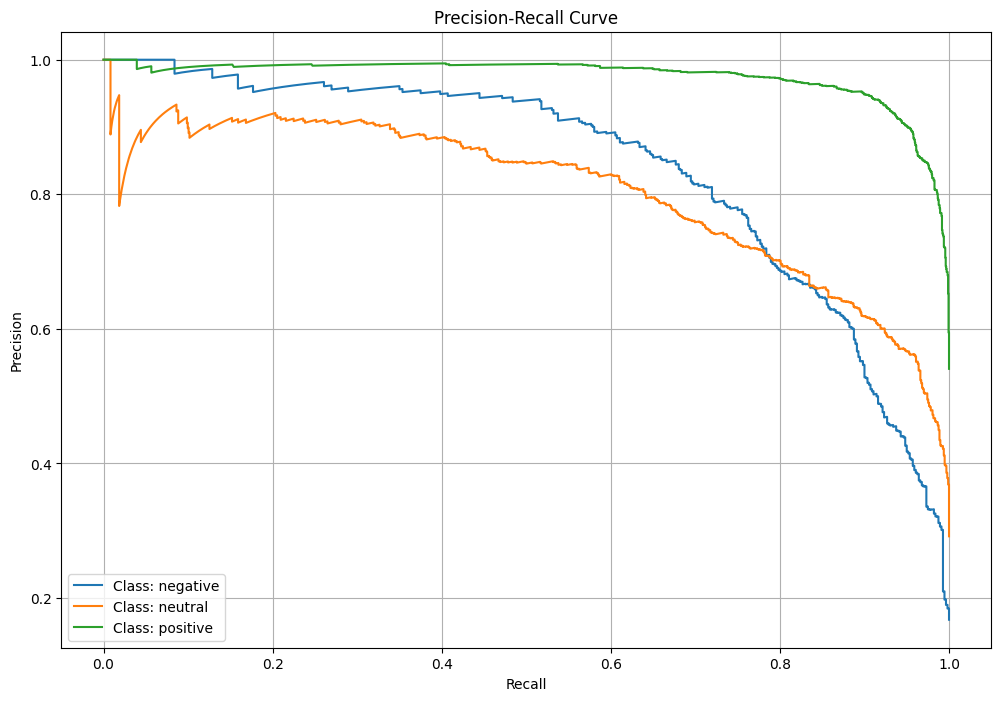

In [16]:
class_names = ['negative', 'neutral', 'positive']
num_classes = len(class_names)
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    true_binary_labels = (true_labels == i).astype(int)
    class_probabilities = probabilities[:, i]
    precision, recall, _ = precision_recall_curve(true_binary_labels, class_probabilities)
    plt.plot(recall, precision, label=f'Class: {class_names[i]}')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [17]:
model.save_pretrained('distilbert_sentiment_model')
tokenizer.save_pretrained('distilbert_sentiment_model')

('distilbert_sentiment_model/tokenizer_config.json',
 'distilbert_sentiment_model/special_tokens_map.json',
 'distilbert_sentiment_model/vocab.txt',
 'distilbert_sentiment_model/added_tokens.json')